# MLP
Laden des auf Hybrid_Datensatz trainierten Modells  
Test auf hybrid_b17_test (= 90% Benign IDS17 + 100% non-BENIGN IDS17)

In [11]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import joblib
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='32_cnn_test.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
ids17_prep_1 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/ids17.parquet'
ids18_prep_1 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/ids18.parquet'
hybrid_train_prep_1 =  '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_train.parquet'
hybrid_test_prep_1 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_test.parquet'

### Laden des Datensatzes

In [13]:
# Datensatz einlesen
df = pd.read_parquet(hybrid_test_prep_1)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)
print(df.columns)

2024-11-19 14:15:56 - INFO - Class distribution
Label
DoS Hulk                        1803160
BENIGN                          1424304
DDoS-LOIC-HTTP                   289328
Botnet Ares                      142921
SSH-BruteForce                    94197
Infiltration - NMAP Portscan      89374
DoS GoldenEye                     22560
DoS Slowloris                      8490
Name: count, dtype: int64


(3874334, 52)
Index(['Fwd IAT Total', 'Dst Port', 'FIN Flag Count', 'Packet Length Variance',
       'Down/Up Ratio', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'URG Flag Count', 'Bwd Packets/s', 'Total TCP Flow Time',
       'Bwd Bulk Rate Avg', 'Total Length of Fwd Packet', 'Bwd IAT Mean',
       'Bwd Packet/Bulk Avg', 'Fwd IAT Max', 'Protocol', 'Flow IAT Min',
       'Bwd Header Length', 'Active Max', 'Total Fwd Packet',
       'Subflow Bwd Packets', 'Fwd Header Length', 'Fwd Seg Size Min',
       'Fwd RST Flags', 'Idle Std', 'Fwd Packet Length Min',
       'Bwd Init Win Bytes', 'Bwd Packet Length Std', 'RST Flag Count',
       'Fwd Act Data Pkts', 'Subflow Fwd Packets', 'ECE Flag Count',
       'SYN Flag Count', 'Bwd URG Flags', 'Average Packet Size', 'Bwd IAT Max',
       'Bwd PSH Flags', 'Total Length of Bwd Packet', 'Bwd RST Flags',
       'Flow Bytes/s', 'Fwd Bulk Rate Avg', 'Fwd IAT Min', 'Active Std',
       'Packet Length Max', 'Bwd IAT Total', 'Fwd IAT Mean',

### Trennen von Features und Labels

In [14]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (3874334, 51)
Form von y: (3874334,)


### Label Encoding für y

In [15]:
label_encoder = joblib.load('label_encoder.pkl')
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]


### Skallierung von X

In [16]:
scaler = joblib.load('scaler.pkl')
X_scaled = scaler.fit_transform(X)

print("Form von X:", X.shape)
print("Form von X_scaled:", X_scaled.shape)

Form von X: (3874334, 51)
Form von X_scaled: (3874334, 51)


In [17]:
X_test, y_test = X_scaled, y_encoded
X_test.shape, y_test.shape

((3874334, 51), (3874334,))

### Überprüfen der Klassenverteilung

In [18]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Testdatensatz:
  Klasse 0: 1424304 Beispiele (36.76%)
  Klasse 1: 142921 Beispiele (3.69%)
  Klasse 2: 289328 Beispiele (7.47%)
  Klasse 3: 22560 Beispiele (0.58%)
  Klasse 4: 1803160 Beispiele (46.54%)
  Klasse 5: 8490 Beispiele (0.22%)
  Klasse 6: 89374 Beispiele (2.31%)
  Klasse 7: 94197 Beispiele (2.43%)



### Laden des Modells

In [19]:
model = keras.models.load_model('model.keras')

### Evaluierung des Modells auf dem Testdatensatz - Klassifikationsbericht und eine Konfusionsmatrix

In [20]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)

121073/121073 ━━━━━━━━━━━━━━━━━━━━ 86s 709us/step
                              precision    recall  f1-score   support

                      BENIGN       0.40      0.98      0.56   1424304
                 Botnet Ares       1.00      0.92      0.96    142921
              DDoS-LOIC-HTTP       0.00      0.00      0.00    289328
               DoS GoldenEye       0.55      0.99      0.71     22560
                    DoS Hulk       0.00      0.00      0.00   1803160
               DoS Slowloris       0.84      0.93      0.88      8490
Infiltration - NMAP Portscan       0.97      0.69      0.81     89374
              SSH-BruteForce       0.91      1.00      0.95     94197

                    accuracy                           0.44   3874334
                   macro avg       0.58      0.69      0.61   3874334
                weighted avg       0.23      0.44      0.29   3874334



Visualisierung der Konfusionsmatrix

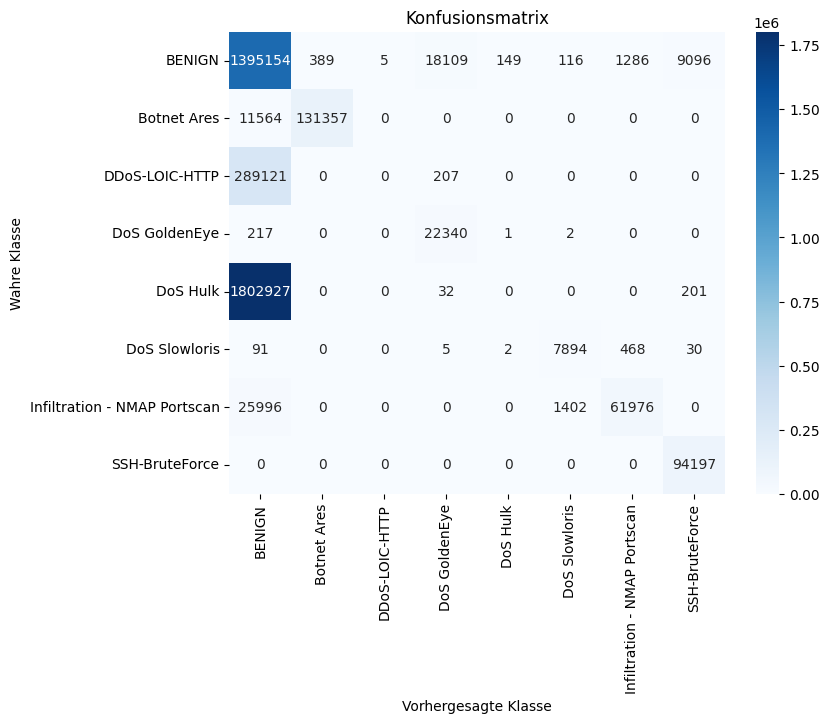

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()
